In [1]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform
import math

import pyreadr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
# from keras.utils import plot_model
# import pydot
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-14.2-arm64-arm-64bit
Tensor Flow Version: 2.18.0
Keras Version: 3.9.0

Python 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ]
Pandas 2.2.2
Scikit-Learn 1.4.2
GPU is NOT AVAILABLE


In [2]:
import os
notebook_dir = "/Users/monamousavi/Dropbox/Causal_climate/My_own_Shared/Takashi_code/Rlearner/Codes"  
os.chdir(notebook_dir)  # Change directory
print(os.getcwd())  


/Users/monamousavi/Dropbox/Causal_climate/My_own_Shared/Takashi_code/Rlearner/Codes


In [3]:

data_2nd_stage = pyreadr.read_r(r'./data_20230504/data_2nd_stage.rds')[None] 
evall_N_seq = pyreadr.read_r(r'./data_20230504/evall_N_seq.rds')[None] 

df_train_sim_id = pd.read_csv('./Output_ann_Train_10fields/df_train_sim_id.csv')

In [4]:
sim_id_train = np.array(df_train_sim_id.iloc[1])
sim_id_train = np.delete(sim_id_train,0,0)

sim_id_train[0]

58

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import copy  # To save best model state

# Define the PyTorch model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Each branch processes the first 3 columns and multiplies its output by T.
        self.branch1 = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.branch2 = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.branch3 = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, inp):
        # inp: (batch_size, 6)
        x = inp[:, :3]    # Features for the dense layers
        T = inp[:, 3:]    # Scaling factors
        T1 = T[:, 0:1]    # (batch_size, 1)
        T2 = T[:, 1:2]
        T3 = T[:, 2:3]
        
        out1 = self.branch1(x) * T1
        out2 = self.branch2(x) * T2
        out3 = self.branch3(x) * T3
        output = out1 + out2 + out3
        return output

# Step 1: Define a weight initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


num_simulations = len(np.unique(data_2nd_stage.sim))
for j in tqdm(range(2)):  
    # Get unique simulation ids from data_2nd_stage 
    sim_ids = np.unique(data_2nd_stage.sim)
    sim_ids_ = np.delete(sim_ids, j, axis=0)
    
    # Get training simulation ids from df_train_sim_id.
    sim_id_train = np.array(df_train_sim_id.iloc[1])
    sim_id_train = np.delete(sim_id_train, 0, axis=0)
    
    sim_id_test = sim_ids[j]
    
  
    dataset = data_2nd_stage[
        (data_2nd_stage['sim'] == sim_id_train[0]) |
        (data_2nd_stage['sim'] == sim_id_train[1]) |
        (data_2nd_stage['sim'] == sim_id_train[2]) |
        (data_2nd_stage['sim'] == sim_id_train[3]) |
        (data_2nd_stage['sim'] == sim_id_train[4]) |
        (data_2nd_stage['sim'] == sim_id_train[5]) |
        (data_2nd_stage['sim'] == sim_id_train[6]) |
        (data_2nd_stage['sim'] == sim_id_train[7]) |
        (data_2nd_stage['sim'] == sim_id_train[8]) |
        (data_2nd_stage['sim'] == sim_id_train[9])
    ].reset_index(drop=True)
    
   
    dataset = dataset[['y_tilde', 'Nk', 'plateau', 'b0', 'T_1_tilde', 'T_2_tilde', 'T_3_tilde']]
    
   
    train_dataset = dataset.sample(frac=0.8)
    val_dataset = dataset.drop(train_dataset.index)
    
    # Separate features and labels
    train_features = train_dataset.copy()
    val_features = val_dataset.copy()
    train_labels = train_features.pop('y_tilde')
    val_labels = val_features.pop('y_tilde')
    
    # Standardize the features based on training data
    scaler = StandardScaler()
    scaler.fit(train_features)
    scaled_train_features = scaler.transform(train_features)
    scaled_val_features = scaler.transform(val_features)
    
    # Convert numpy arrays to PyTorch tensors
    X_train = torch.tensor(scaled_train_features, dtype=torch.float32).to(device)
    y_train = torch.tensor(train_labels.values, dtype=torch.float32).unsqueeze(1).to(device)
    X_val = torch.tensor(scaled_val_features, dtype=torch.float32).to(device)
    y_val = torch.tensor(val_labels.values, dtype=torch.float32).unsqueeze(1).to(device)
    
    # Create DataLoader for training data
    train_dataset_tensor = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset_tensor, batch_size=512, shuffle=True)
    
    # Initialize the model, apply weight initialization, loss function and optimizer
    model = MyModel().to(device)
    model.apply(init_weights)  # Apply Xavier initialization
    criterion = nn.L1Loss()     # Mean absolute error loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Step 2: Training loop with early stopping and checkpointing
    best_val_loss = np.inf
    best_model_wts = None
    patience = 10
    counter = 0
    num_epochs = 500
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_X.size(0)
            
        train_loss = running_loss / len(train_loader.dataset)
        
        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
        
        # Check if validation loss improved, and if so, save model state
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            
        if counter >= patience:
            print(f"Early stopping at epoch {epoch} for sim_id {sim_id_test}")
            break
       
        # print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")
    
    # Restore best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
        
    # Predict on the validation set
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val).cpu().numpy().flatten()
    
    outcome_val = pd.DataFrame({'pred': val_preds, 'true': val_labels.values})
    outcome_val.to_csv('./Pytorch_outcome_ten_field/validation_{}.csv'.format(sim_id_test), index=False)
    
    ## EONR estimation 
    p_corn = 6.25 / 25.4  
    p_N = 1 / 0.453592   
    
    test_dataset = data_2nd_stage[data_2nd_stage['sim'] == sim_id_test]
    features = test_dataset[['Nk', 'plateau', 'b0']]
    
    test_evall_N_seq = evall_N_seq[evall_N_seq['sim'] == sim_id_test].reset_index(drop=True)
    Nseq = test_evall_N_seq['N'].values
    n_row = test_dataset.shape[0]
    
    estEONR_vector = []
    
    for i in range(n_row):
        feature_1 = features.iloc[i, :]
        rep_feature_1 = pd.concat([feature_1] * 100, axis=1).T
        rep_feature_1.reset_index(drop=True, inplace=True)
        rep_feature_1 = pd.concat([rep_feature_1, test_evall_N_seq.iloc[:, 0:3]], axis=1)
        rep_feature_1.rename(columns={'T_1': 'T_1_tilde', 'T_2': 'T_2_tilde', 'T_3': 'T_3_tilde'}, inplace=True)
        
        # Scale the features using the previously fitted scaler
        scaled_feature_1 = scaler.transform(rep_feature_1)
        X_feature = torch.tensor(scaled_feature_1, dtype=torch.float32).to(device)
        
        with torch.no_grad():
            prediction = model(X_feature).cpu().numpy().reshape(-1)
        
        MP = prediction * p_corn - Nseq * p_N
        estEONR = Nseq[np.argmax(MP)]
        estEONR_vector.append(estEONR)
        
    outcome = pd.DataFrame({'pred': estEONR_vector, 'true': test_dataset['opt_N'].values})
    outcome.to_csv('./Pytorch_outcome_ten_field/EONR_{}.csv'.format(sim_id_test), index=False)
    
    # we can save the training simulation ids if needed.
    # df_train_sim_id = pd.concat([df_train_sim_id, pd.DataFrame(sim_id_train).T])
    
# we can save df_train_sim_id at the end:
# df_train_sim_id.reset_index(inplace=True)
# df_train_sim_id.to_csv('./Output_Rann/df_train_sim_id.csv', index=False)


  0%|          | 0/2 [00:00<?, ?it/s]

Early stopping at epoch 195 for sim_id 1


 50%|█████     | 1/2 [00:14<00:14, 14.84s/it]

Early stopping at epoch 127 for sim_id 2


100%|██████████| 2/2 [00:25<00:00, 12.68s/it]


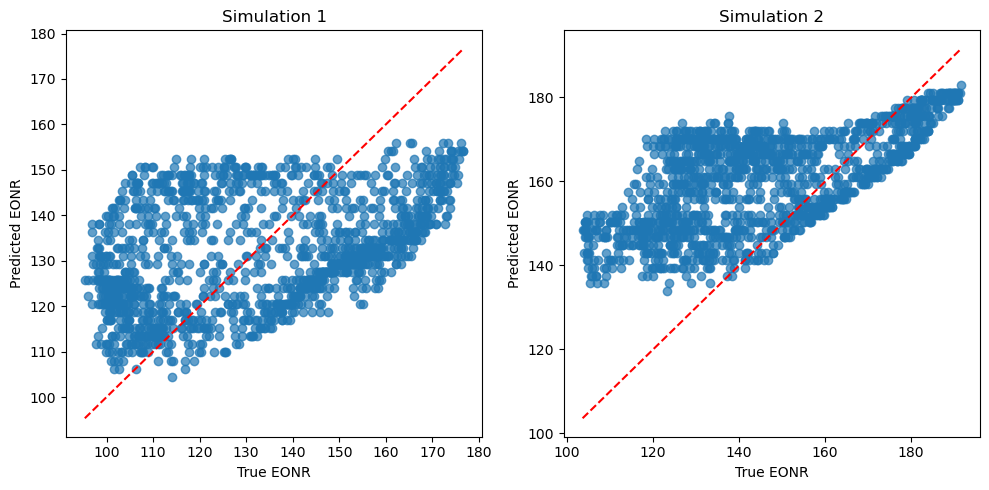

In [ ]:
import glob
import math
import pandas as pd
import matplotlib.pyplot as plt

# all EONR CSV files
file_list = glob.glob('./Pytorch_outcome_ten_field/EONR_*.csv')
num_files = len(file_list)

# grid layout
cols = 2
rows = math.ceil(num_files / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)

for idx, file in enumerate(file_list):
    # read CSV without index_col so pred and true become columns
    df = pd.read_csv(file)  

    r, c = divmod(idx, cols)
    ax = axes[r, c]
    
    #  plot of true vs predicted EONR
    ax.scatter(df['true'], df['pred'], alpha=0.7)
    ax.set_xlabel('True EONR')
    ax.set_ylabel('Predicted EONR')
    
    # get simulation id from filename
    sim_id = file.split('_')[-1].replace('.csv', '')
    ax.set_title(f"Simulation {sim_id}")
    
    # plot y = x 
    min_val = min(df['true'].min(), df['pred'].min())
    max_val = max(df['true'].max(), df['pred'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')

# If we have more subplots than files, remove unused axes
for idx in range(num_files, rows*cols):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()
